<table>
<tr>                                                                                   
     <th>
         <div style='padding:15px;color:#030aa7;font-size:240%;text-align: center;font-style: italic;font-weight: bold;font-family: Georgia, serif'><a href="https://www.kaggle.com/datasets/adityakadam1/footwear">Reconnaissance des Chaussures - Vision Transformers</a></div>
     </th>
     <th><img src="https://raw.githubusercontent.com/rbizoi/DeepLearning/refs/heads/main/images/chaussures.png" width="96"></th>
 </tr>
</table>

**Reconnaissance des Chaussures**<br>
Le jeu de données contient **3 000** images de fleurs étiquetées en **3** classes.

<table>
    <tr>                                                                                   
         <th  style="text-align:left;background-color:#053061;color:white;">Valeur</th>
         <th  style="text-align:left;background-color:#053061;color:white;">Nom classe</th>
     </tr>
    <tr>
        <th  style="text-align:left">0</th>
        <th  style="text-align:left">Botte</th>
    </tr>
    <tr>
        <th  style="text-align:left">1</th>
        <th  style="text-align:left">Sandale</th>
    </tr>
    <tr>
        <th  style="text-align:left">2</th>
        <th  style="text-align:left">Chaussure</th>
    </tr>
</table>

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Initialisation du document</div></b>


## Introduction

This example implements the [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929)
model by Alexey Dosovitskiy et al. for image classification,
and demonstrates it on the CIFAR-100 dataset.
The ViT model applies the Transformer architecture with self-attention to sequences of
image patches, without using convolution layers.

# Préparation de l’environnement

In [1]:
import os
# import json
# @param ["tensorflow", "jax", "torch"]
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['KERAS_BACKEND'] = 'tensorflow'  
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
# os.environ['TF_XLA_FLAGS']='--tf_xla_auto_jit=1,--tf_xla_always_defer_compilation=true'
# os.environ['XLA_FLAGS']='--xla_backend_optimization_level=0,--xla_gpu_autotune_level=4,--xla_gpu_disable_ptxas_optimizations=true,--xla_gpu_use_cudnn_batchnorm_level=2'
# os.environ['TF_GPU_ALLOCATOR']='cuda_malloc_async'
os.environ['TF_CPP_MIN_LOG_LEVEL']='5'

# Import librairies

In [2]:
import keras, keras_cv, pandas as pd, numpy as np
from keras import layers
from keras import ops


import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
print("Tensorflow\t : %s\tCUDA %s\tGPU %s\tXLA %s\nKeras\t\t : %s\nKerasCV\t\t : %s\nPandas\t\t : %s\nNumPy\t\t : %s"%
      (tf.__version__, 
       tf.test.is_built_with_cuda(), 
       tf.test.is_built_with_gpu_support(), 
       tf.test.is_built_with_xla(), 
       keras.__version__, 
       keras_cv.__version__ , 
       pd.__version__, 
       np.__version__))

Tensorflow	 : 2.17.0	CUDA True	GPU True	XLA True
Keras		 : 3.6.0
KerasCV		 : 0.9.0
Pandas		 : 2.2.2
NumPy		 : 1.26.4


In [4]:
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if len(physical_devices) >  0 :
    for i, gpu in enumerate(physical_devices):
        tf.config.experimental.set_memory_growth(physical_devices[i], True)

    strategy = tf.distribute.experimental.CentralStorageStrategy()
    print('Le système est initialisé avec {0:d} GPUs'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:ParameterServerStrategy (CentralStorageStrategy if you are using a single machine) with compute_devices = ['/job:localhost/replica:0/task:0/device:GPU:0'], variable_device = '/job:localhost/replica:0/task:0/device:GPU:0'
Le système est initialisé avec 1 GPUs


I0000 00:00:1752065947.629389 3199754 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1752065947.651756 3199754 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1752065947.651880 3199754 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1752065947.658664 3199754 service.cc:146] XLA service 0xf2efc50 initialized for platform

# Initialise projet

In [5]:
nom_projet                = "12-ControleImagesApprentissageVit--Chaussures-TFRecods"
repertoireProjet          = os.path.join(os.getcwd(),nom_projet)
repertoireEnregistrement  = os.path.join(repertoireProjet,'repertoire.images')
repertoireSauvegardes     = os.path.join(repertoireProjet,'repertoire.sauvegardes')

repertoireModelCKP        = os.path.join(repertoireSauvegardes,'model.checkpoints')
repertoireModelSauvegarde = os.path.join(repertoireSauvegardes,'model.sauvegarde')
repertoireModelLogs       = os.path.join(repertoireSauvegardes,'model.tensorboard')

def controleExistenceRepertoire(directory, create_if_needed=True):
    """Voir si le répertoire existe. S'il n'existe pas il est créé."""
    path_exists = os.path.exists(directory)
    if path_exists:
        if not os.path.isdir(directory):
            raise Exception("Trouvé le nom "+directory+" mais c'est un fichier, pas un répertoire")
            return False
        return True
    if create_if_needed:
        os.makedirs(directory)
        
controleExistenceRepertoire(repertoireProjet)
controleExistenceRepertoire(repertoireEnregistrement)
controleExistenceRepertoire(repertoireSauvegardes)

controleExistenceRepertoire(repertoireModelCKP)
controleExistenceRepertoire(repertoireModelSauvegarde)
controleExistenceRepertoire(repertoireModelLogs)

def sauvegarderImage(filename,repertoireEnregistrement=repertoireEnregistrement):
    """Enregistrez la figure. Appelez la méthode juste avant plt.show ()."""
    controleExistenceRepertoire(repertoireEnregistrement)
    plt.savefig(os.path.join(repertoireEnregistrement,filename+'.png'), dpi=600, bbox_inches='tight')

# Configurer les hyperparamètres

In [6]:
num_classes = 2
image_size = 128
input_shape = (image_size, image_size, 3)

learning_rate = 0.01
weight_decay = 0.0001
batch_size = 48
num_epochs = 8 
 
patch_size = 16  # Size of the patches to be extract from the input images
num_heads = image_size // patch_size #12

num_patches = num_heads ** 2

projection_dim = 64
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers

transformer_layers = 16
mlp_head_units = [
    4048,
    2048,
]  # Size of the dense layers of the final classifier


# Lecture des données TFRecords

In [7]:
augmentation = keras.Sequential(
    [
        keras.layers.Resizing(image_size,image_size),
        keras.layers.RandomFlip('horizontal_and_vertical'),
        keras.layers.RandomRotation(factor=0.2),
        keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],)

initialisation = keras.Sequential(
    [
        keras.layers.Resizing(image_size,image_size),
    ],)


In [8]:
def _traitementImage(image):
    # return (tf.cast(tf.image.decode_jpeg(image, channels=input_shape[2]), tf.float32)/255.0) - 0.5
    return tf.cast(initialisation(tf.image.decode_jpeg(image, channels=input_shape[2])), tf.float32)

In [9]:
def _lectureTFRecord(enregistrement):
    formatTFRecord = ({
        'image': tf.io.FixedLenFeature([], tf.string),
        'label':  tf.io.FixedLenFeature([], tf.int64),
    })

    enregistrement = tf.io.parse_single_example(enregistrement, formatTFRecord)
    enregistrement['image'] =  _traitementImage(enregistrement['image'])
    return enregistrement

In [10]:
def _dictToImageLabel(enregistrement):
    return enregistrement['image'],enregistrement['label']

In [11]:
VALIDATION_DATA_PATH_PATTERN = '/home/razvan/documentation/DeepLearning/donnees/tfRecords/chaussures-bin-validation.tfrecords'
validation = tf.data.TFRecordDataset(tf.io.gfile.glob(VALIDATION_DATA_PATH_PATTERN))
validation = validation.map(_lectureTFRecord)
validation = validation.map(_dictToImageLabel)
validation = validation.batch(100)
validation = validation.prefetch(tf.data.AUTOTUNE)  

x_test, y_test = next(iter(validation))

In [12]:
TRAIN_DATA_PATH_PATTERN = '/home/razvan/documentation/DeepLearning/donnees/tfRecords/chaussures-bin-apprentissage.tfrecords'
apprentissage = tf.data.TFRecordDataset(tf.io.gfile.glob(TRAIN_DATA_PATH_PATTERN))
apprentissage = apprentissage.map(_lectureTFRecord)
apprentissage = apprentissage.map(_dictToImageLabel)
apprentissage = apprentissage.batch(batch_size)
apprentissage = apprentissage.prefetch(tf.data.AUTOTUNE)  

VALIDATION_DATA_PATH_PATTERN = '/home/razvan/documentation/DeepLearning/donnees/tfRecords/chaussures-bin-validation.tfrecords'
validation = tf.data.TFRecordDataset(tf.io.gfile.glob(VALIDATION_DATA_PATH_PATTERN))
validation = validation.map(_lectureTFRecord)
validation = validation.map(_dictToImageLabel)
validation = validation.batch(batch_size)
validation = validation.prefetch(tf.data.AUTOTUNE)  

In [13]:
x_train, y_train = next(iter(apprentissage))

# Utiliser l'augmentation des données

In [14]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


## Implement patch creation as a layer

In [15]:

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config


Let's display patches for a sample image

W0000 00:00:1752065948.444107 3199754 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1752065948.464720 3199754 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1752065948.466293 3199754 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1752065948.466526 3199754 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1752065948.467295 3199754 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1752065948.515168 3199754 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1752065948.515391 3199754 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1752065948.515631 3199754 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1752065948.515870 3199754 gp

Image size: 128 X 128
Patch size: 16 X 16
Patches per image: 64
Elements per patch: 768


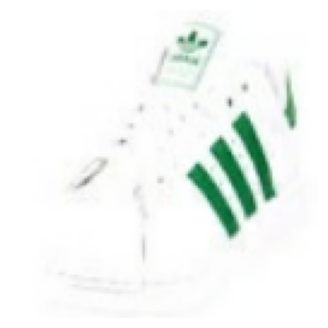

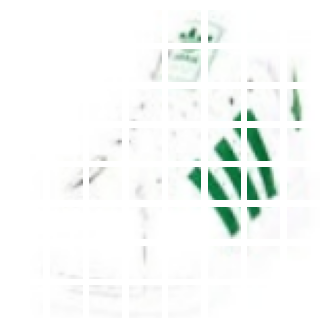

In [16]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))].numpy()
plt.imshow(image.astype("uint8")) #, cmap='gray'
plt.axis("off")

resized_image = ops.image.resize(
    ops.convert_to_tensor([image], dtype="float16"), size=(image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, input_shape[2]))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8")) #, cmap='gray'
    plt.axis("off")

## Implement the patch encoding layer

The `PatchEncoder` layer will linearly transform a patch by projecting it into a
vector of size `projection_dim`. In addition, it adds a learnable position
embedding to the projected vector.

In [17]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config


## Build the ViT model

The ViT model consists of multiple Transformer blocks,
which use the `layers.MultiHeadAttention` layer as a self-attention mechanism
applied to the sequence of patches. The Transformer blocks produce a
`[batch_size, num_patches, projection_dim]` tensor, which is processed via an
classifier head with softmax to produce the final class probabilities output.

Unlike the technique described in the [paper](https://arxiv.org/abs/2010.11929),
which prepends a learnable embedding to the sequence of encoded patches to serve
as the image representation, all the outputs of the final Transformer block are
reshaped with `layers.Flatten()` and used as the image
representation input to the classifier head.
Note that the `layers.GlobalAveragePooling1D` layer
could also be used instead to aggregate the outputs of the Transformer block,
especially when the number of patches and the projection dimensions are large.

## Implement multilayer perceptron (MLP)

In [18]:
print(f"""
input_shape        : {input_shape}
num_classes        : {num_classes}
--------------------------------------------------------------------
num_patches        : {num_patches}
projection_dim     : {projection_dim}
--------------------------------------------------------------------
batch_size         : {batch_size   }
num_epochs         : {num_epochs   }
--------------------------------------------------------------------
transformer_layers : {transformer_layers}
num_heads          : {num_heads}
transformer_units  : {transformer_units}
mlp_head_units     : {mlp_head_units}
--------------------------------------------------------------------
learning_rate      : {learning_rate}
weight_decay       : {weight_decay }
""")


input_shape        : (128, 128, 3)
num_classes        : 2
--------------------------------------------------------------------
num_patches        : 64
projection_dim     : 64
--------------------------------------------------------------------
batch_size         : 48
num_epochs         : 8
--------------------------------------------------------------------
transformer_layers : 16
num_heads          : 8
transformer_units  : [128, 64]
mlp_head_units     : [4048, 2048]
--------------------------------------------------------------------
learning_rate      : 0.01
weight_decay       : 0.0001



In [19]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [20]:

def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


## Compile, train, and evaluate the mode

In [21]:
tf.keras.backend.clear_session()

In [22]:
with strategy.scope():
    vit_classifier = create_vit_classifier()

In [23]:
# vit_classifier.summary()

In [24]:
# keras.utils.plot_model(vit_classifier, os.path.join(repertoireEnregistrement,"ControleImagesApprentissageVisionTransformer.png"))

In [25]:
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay, use_ema=True,
    )

    model.compile(
        optimizer=optimizer,
        loss= keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            # keras.metrics.SparseTopKCategoricalAccuracy(),
        ],
    )

    chkp_fichier = os.path.join(repertoireModelCKP,'checkpoint.weights.h5')
    chkp_call_val_accuracy = keras.callbacks.ModelCheckpoint(
        chkp_fichier,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    chkp_call_val_loss = keras.callbacks.ModelCheckpoint(
        chkp_fichier,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
        mode="auto",
    )
    callbkTensorBoard = tf.keras.callbacks.TensorBoard(log_dir=repertoireModelLogs)
    
    callbkBackupAndRestore = tf.keras.callbacks.BackupAndRestore(backup_dir=repertoireModelCKP)

    
    if os.path.exists(chkp_fichier):
        if not os.path.isdir(chkp_fichier):
            model.load_weights(chkp_fichier)    

    history = model.fit(apprentissage, 
                        epochs=num_epochs, 
                        validation_data=validation,
                        callbacks=[chkp_call_val_accuracy,chkp_call_val_loss,callbkBackupAndRestore,callbkTensorBoard])

    return history

In [26]:
with strategy.scope():
    history = run_experiment(vit_classifier)   

57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.8089 - loss: 0.8217 - val_accuracy: 0.8800 - val_loss: 0.3651
Epoch 3/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.8047 - loss: 0.6985 - val_accuracy: 0.9033 - val_loss: 0.3458
Epoch 4/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - accuracy: 0.8152 - loss: 0.4273 - val_accuracy: 0.9167 - val_loss: 0.2227
Epoch 5/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 0.8314 - loss: 0.4423 - val_accuracy: 0.9300 - val_loss: 0.1824
Epoch 6/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.8407 - loss: 0.4379 - val_accuracy: 0.8867 - val_loss: 0.2888
Epoch 7/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.8027 - loss: 0.6627 - val_accuracy: 0.9267 - val_loss: 0.1733
Epoch 8/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.8215 - loss: 0.4061 - val_accuracy: 0.9367 - val_loss: 0.1982


In [27]:
history = pd.DataFrame( history.history)
history.reset_index(inplace=True)
history.rename(columns={'index':'epoch'},inplace=True)

Text(0.5, 1.0, 'Loss ')

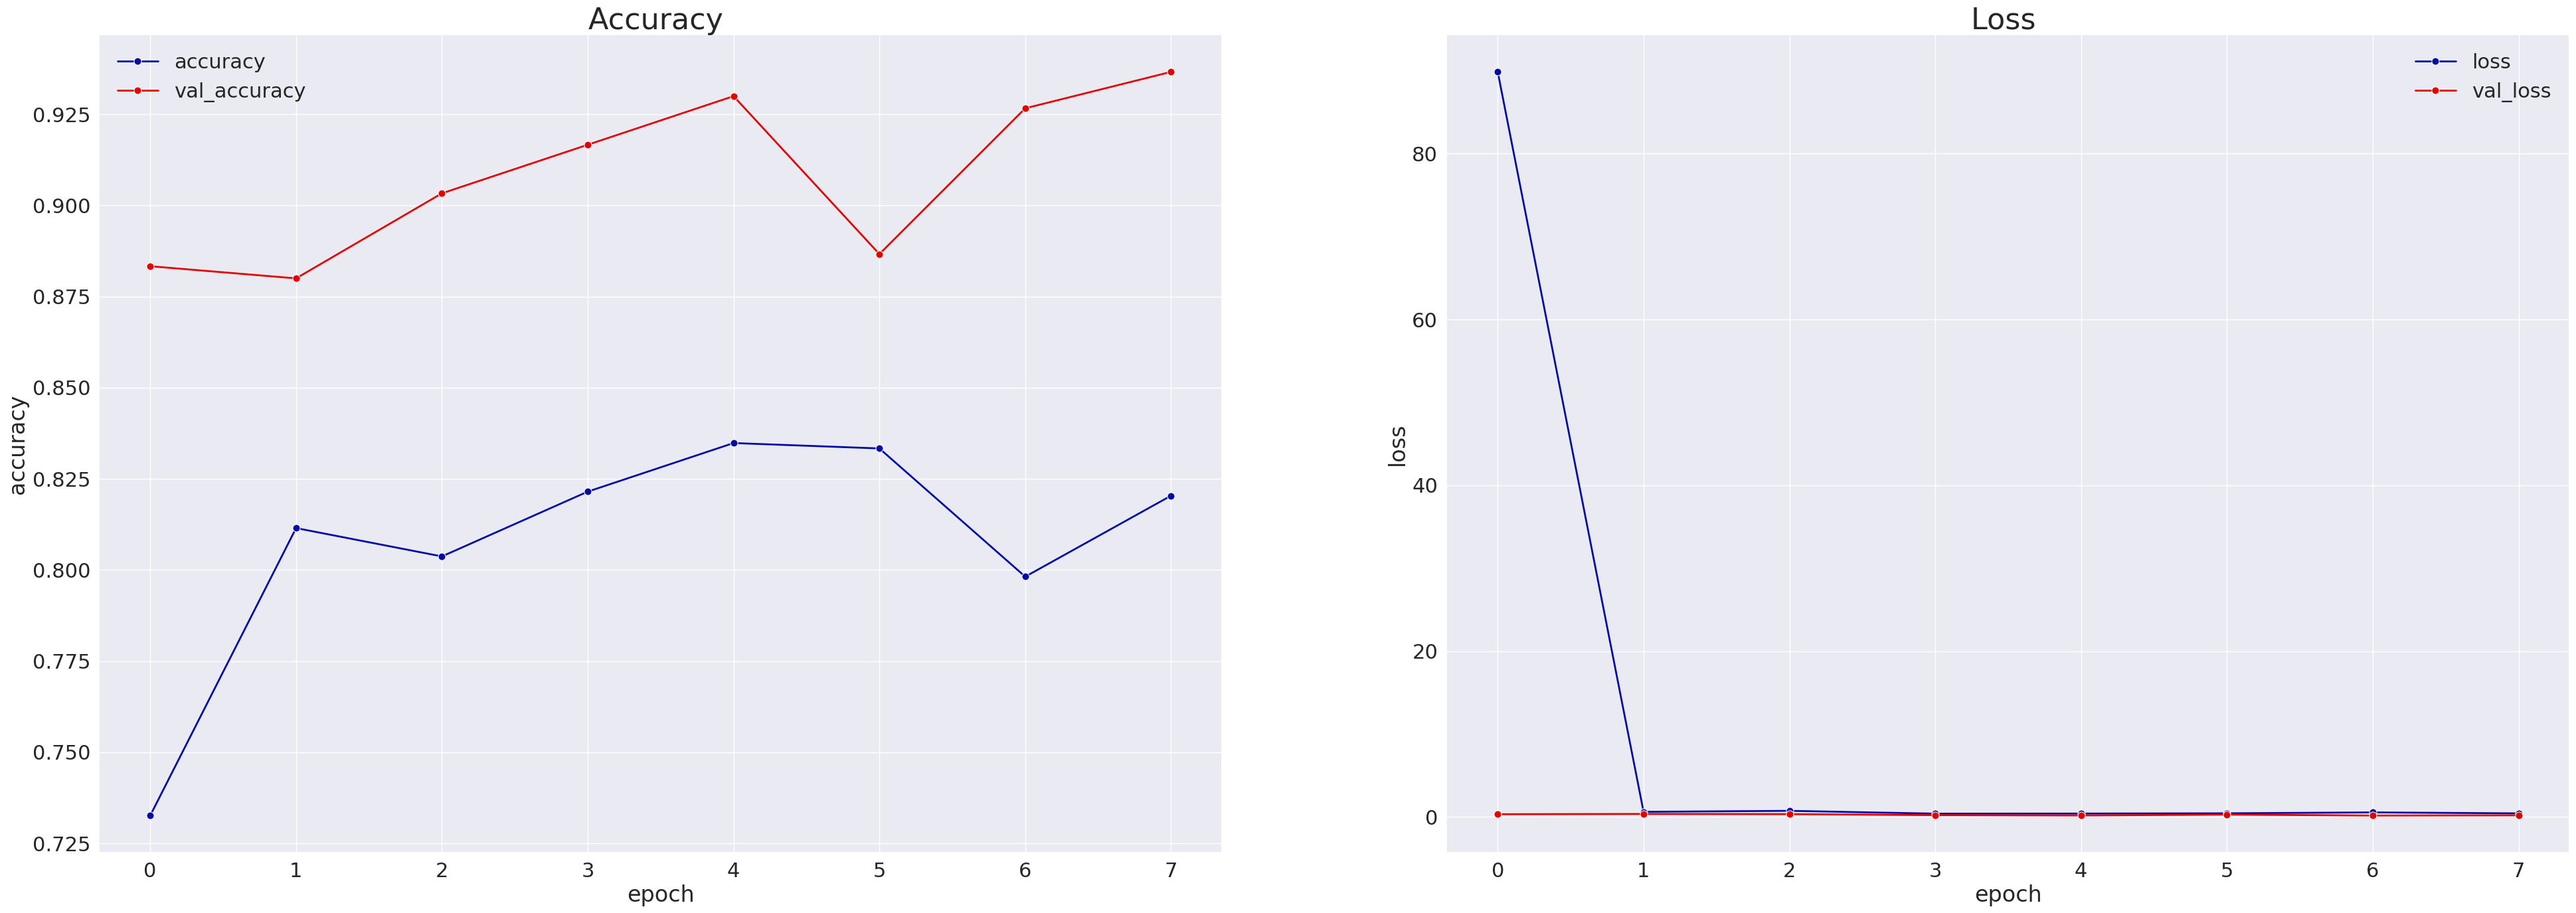

In [28]:
import seaborn as sns
import matplotlib.font_manager as fm


if int(str(sns.__version__).split('.')[1]) > 8 : 
    plt.style.use('seaborn-v0_8-darkgrid')
else:
    plt.style.use('seaborn-darkgrid')
    
sns.set(font_scale=2)

palette = [
            "#030aa7", "#e50000", "#d8863b", "#005f6a", "#6b7c85", "#751973", "#d1e5f0", "#fddbc7",
            "#ffffcb", "#12e193", "#d8dcd6", "#ffdaf0", "#dfc5fe", "#f5054f", "#a0450e",
            "#0339f8", "#f4320c", "#fec615", "#017a79", "#85a3b2", "#fe2f4a", "#a00498", "#b04e0f",
            "#0165fc", "#ff724c", "#fddc5c", "#11875d", "#89a0b0", "#fe828c", "#cb00f5", "#b75203",
            "#0485d1", "#ff7855", "#fbeeac", "#0cb577", "#95a3a6", "#ffb7ce", "#c071fe", "#ca6b02",
            "#92c5de", "#f4a582", "#fef69e", "#18d17b", "#c5c9c7", "#ffcfdc", "#caa0ff", "#cb7723",
            "#d1e5f0", "#fddbc7", "#ffffcb", "#12e193", "#d8dcd6", "#ffdaf0", "#dfc5fe", "#d8863b",
            "#030764", "#be0119", "#dbb40c", "#005249", "#3c4142", "#cb0162", "#5d1451", "#653700",
            "#040348", "#67001f", "#b27a01", "#002d04", "#000000", "#a0025c", "#490648", "#3c0008"
          ]

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(48,16));
markersize = 8
linewidth=2

graph = sns.lineplot(x='epoch', 
                     y='accuracy',  
                     data=history,
                     ax=ax[0],      
                     label='accuracy',
                     err_style=None, 
                     marker='o',
                     markersize=markersize,
                     linewidth=linewidth,
                     color=palette[0],
                     );
graph = sns.lineplot(x='epoch', 
                     y='val_accuracy',  
                     data=history,
                     ax=ax[0],      
                     label='val_accuracy',
                     err_style=None, 
                     marker='o',
                     markersize=markersize,
                     linewidth=linewidth,
                     color=palette[1],
                     );
    
ax[0].set_title(f'Accuracy ', fontproperties=fm.FontProperties(size=32))

graph = sns.lineplot(x='epoch', 
                     y='loss',  
                     data=history,
                     ax=ax[1],      
                     label='loss',
                     err_style=None, 
                     marker='o',
                     markersize=markersize,
                     linewidth=linewidth,
                     color=palette[0],
                     );
graph = sns.lineplot(x='epoch', 
                     y='val_loss',  
                     data=history,
                     ax=ax[1],      
                     label='val_loss',
                     err_style=None, 
                     marker='o',
                     markersize=markersize,
                     linewidth=linewidth,
                     color=palette[1],
                     );
ax[1].set_title(f'Loss ', fontproperties=fm.FontProperties(size=32))

In [36]:
sauvegardePoids = os.path.join(repertoireSauvegardes,'modelViT.weights.h5')
vit_classifier.save_weights(sauvegardePoids) 

In [37]:
chkp_fichier = os.path.join(repertoireSauvegardes,'modelViT.weights.h5')
vit_classifier.load_weights(chkp_fichier)

In [39]:
accuracy, top_5_accuracy = vit_classifier.evaluate(x_test, y_test)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9416 - loss: 0.1629 
Test accuracy: 17.29%
Test top 5 accuracy: 94.0%


In [ ]:
batch_size = 2
num_epochs = 16 

with strategy.scope():
    history = run_experiment(vit_classifier)   

/home/razvan/anaconda3/envs/keras3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 803 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 2/16
     57/Unknown 16s 43ms/step - accuracy: 0.6630 - loss: 0.6700